In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

import scipy.io as sio #allows for importing of .mat files 
from elephant.spike_train_generation import homogeneous_poisson_process
from quantities import Hz, s, ms

# Parameters

In [2]:
#%% parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 0.6 # v threshold
tau_out = 3 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 2 # refractory period /// unit: ms

decays = np.array([lr, thr, alpha, beta, kappa, rho, t_ref]) # save as a vector

#  Neural data input preparation

In [79]:
nb_inputs, nb_hidden, nb_outputs  = 285, 100, 4

rootDir = ''
fn = 'contdata95.mat'

# load the mat file
mat = sio.loadmat(rootDir+fn)

# Get each variable from the mat file
# (Flipping X and Y so that X = neural data, Y = kinematics)
nsamp = 500 # 31413 total
x = mat['Y'][:nsamp,:]
y = mat['X'][:nsamp,0:2] # Only load x and y position

conv_size = 3
# Add the previous 3 time bins features as a feature in the current time bin
x_new = np.zeros((x.shape[0],x.shape[1]*conv_size))
for k1 in range(conv_size-1):
    k = k1+1
    x_new[k:, int(x.shape[1]*k):int(x.shape[1]*(k+1))] = x[0:-k, :]
x = x_new

### Prepare X spike train
# Normalize 0-1
x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

# Generate spike train
# I used the method described in https://praneethnamburi.com/2015/02/05/simulating-neural-spike-trains/
# Much more simple
import random
T = 0.1  # total time in sec
dt = 0.001  # time interval in sec
bins = int(T / dt)  
x_spikes = np.zeros((x_norm.shape[0],bins,x_norm.shape[1]))
random.seed(9)
for ss in range(0,x_norm.shape[0]): # samples
    for nn in range(0,x_norm.shape[1]): # neurons
        xt = x_norm[ss,nn]
        fr = xt * 100  # firing rate in Hz (range 0-100)
        for bb in range(bins):
            p = random.random()
            if p < fr * dt:
                x_spikes[ss,bb,nn] = 1 # spike


### Prepare Y classes
# Quad 1 = -x,+y
# Quad 2 = +x,+y
# Quad 3 = +x,-y
# Quad 4 = -x,-y
y_class = np.zeros((nsamp,bins,1))
y_class_1hot = np.zeros((nsamp,bins,4))
for ii in range(len(y_class)):
    xpos = y[ii,0]
    ypos = y[ii,1]
    if xpos<0 and ypos>0:
        y_class[ii,:] = 1
        y_class_1hot[ii,:,0] = 1
    elif xpos>0 and ypos>0:
        y_class[ii,:] = 2
        y_class_1hot[ii,:,1] = 1
    elif xpos>0 and ypos<0:
        y_class[ii,:] = 3
        y_class_1hot[ii,:,2] = 1
    else:
        y_class[ii,:] = 4
        y_class_1hot[ii,:,3] = 1

x = x_spikes
y = y_class - 1
y1hot = y_class_1hot

# Larger value of x corresponds to more spikes = good
print(x_norm[0,0])
print(np.sum(x[0,:,0]))
print(x_norm[300,95])
print(np.sum(x[300,:,95]))

# Split into batches 
# Test one batch for now
nb_batch = 1 # number of batches
x = x.reshape((nb_batch,nsamp,bins,nb_inputs))
y = y.reshape((nb_batch,nsamp,bins,1))
y1hot = y1hot.reshape((nb_batch,nsamp,bins,nb_outputs))
print(x.shape)
print(y.shape)
print(y1hot.shape)

# Cue
cue_on = np.zeros((100),dtype=bool)
dur_stim = 10
cue_on[(100-dur_stim):] = 1

0.0
0.0
0.23529411764705882
3.0
(1, 500, 100, 285)
(1, 500, 100, 1)
(1, 500, 100, 4)


# Initialize weights

In [80]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

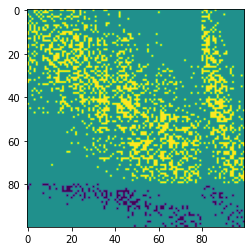

In [81]:
#%% recurrent weights (choose only one)
############### (1) random network ###############
# wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
# np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

# Training (still debugging)

In [82]:
#%% compile (1st run numba is slow)
x_tmp, y1hot_tmp, y_tmp, cue_on_tmp = x[0,:,:,:].copy(),y1hot[0,:,:,:].copy(),y[0,:,:,:],cue_on.copy()
loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_tmp, y1hot_tmp, cue_on_tmp,decays)
print('compile done.')
print(out_rec[:,cue_on,:].shape)

# Validate
batch_size = 500
pi = out_rec[:,cue_on,:]/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) 
pi_m = pi.mean(1)
print(np.argmax(pi_m,axis=1))
print(y_tmp[:,0,0])
# (np.argmax(pi_m,axis=1) == y_tmp[:,cue_on][:,-1]).mean() 

# pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) 
# pi_m = pi.mean(1)
# (np.argmax(pi_m,axis=1) == y_batch[:,cue_on][:,-1]).mean() 

compile done.
(500, 10, 4)
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 3 0 3 0 0 0 0 0 1 2 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 3 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 0
 0 0 0 0 0 2 2 0 0 0 0 0 1 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 3 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 0 0 2 0 0 

In [83]:
#%% run train
dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr, w1s, w2s, biases = [],[],[],[],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 30

# Adam
m_t_w1 = np.zeros((nb_inputs,nb_hidden))
m_t_w2 = np.zeros((nb_hidden,nb_outputs))
m_t_wr = np.zeros((nb_hidden,nb_hidden))
m_t_bias = np.zeros((nb_outputs,))

v_t_w1 = np.zeros((nb_inputs,nb_hidden))
v_t_w2 = np.zeros((nb_hidden,nb_outputs))
v_t_wr = np.zeros((nb_hidden,nb_hidden))
v_t_bias = np.zeros((nb_outputs,))

b1 = 0.9
b2 = 0.999
alpha_lr = 0.002
eps = 1e-9

nb_batch = 2
for epoch in range(n_epochs): # 100
    ######################### train #########################
    loss_batch,acc_batch,fr_batch = np.zeros((nb_batch-1,)), np.zeros((nb_batch-1,)), np.zeros((nb_batch-1,))
    for batch_idx in range(nb_batch-1): # batch_idx = 0
        x_batch,y1hot_batch,y_batch = x[batch_idx],y1hot[batch_idx],y[batch_idx]
        loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_batch,y1hot_batch,cue_on,decays)

        # Adam
        # m_t_w1 = b1 * m_t_w1 + (1 - b1) / (-lr) * np.mean(dw1, 0)
        # m_t_w2 = b1 * m_t_w2 + (1 - b1) / (-lr) * np.mean(dw2, 0)
        # m_t_wr = b1 * m_t_wr + (1 - b1) / (-lr) * np.mean(dwr, 0)
        # m_t_bias = b1 * m_t_bias + (1 - b1) / (-lr) * np.mean(dbias, 0)

        # v_t_w1 = b2 * v_t_w1 + (1 - b2) / (lr**2) * np.power(np.mean(dw1, 0), 2)
        # v_t_w2 = b2 * v_t_w2 + (1 - b2) / (lr**2) * np.power(np.mean(dw2, 0), 2)
        # v_t_wr = b2 * v_t_wr + (1 - b2) / (lr**2) * np.power(np.mean(dwr, 0), 2)
        # v_t_bias = b2 * v_t_bias + (1 - b2) / (lr**2) * np.power(np.mean(dbias, 0), 2)

        # t = (epoch + 1)

        # m_w1_corr = m_t_w1 / (1. - b1**t)
        # m_w2_corr = m_t_w2 / (1. - b1**t)
        # m_wr_corr = m_t_wr / (1. - b1**t)
        # m_bias_corr = m_t_bias / (1. - b1**t)

        # v_w1_corr = v_t_w1 / (1. - b2**t)
        # v_w2_corr = v_t_w2 / (1. - b2**t)
        # v_wr_corr = v_t_wr / (1. - b2**t)
        # v_bias_corr = v_t_bias / (1. - b2**t)

        # div_w1 = -alpha_lr * m_w1_corr / (np.sqrt(v_w1_corr) + eps * np.ones_like(v_w1_corr))
        # div_w2 = -alpha_lr * m_w2_corr / (np.sqrt(v_w2_corr) + eps * np.ones_like(v_w2_corr))
        # div_wr = -alpha_lr * m_wr_corr / (np.sqrt(v_wr_corr) + eps * np.ones_like(v_wr_corr))
        # div_bias = -alpha_lr * m_bias_corr / (np.sqrt(v_bias_corr) + eps * np.ones_like(v_bias_corr))

        # w1 += div_w1 # input-->hidden update
        # w2 += div_w2 # hidden-->hidden update
        # wr += div_wr # hidden-->output update
        # bias += div_bias # bias update

        # Momemtum
        dw1_past = 0.9*dw1_past + np.mean(dw1,0) #!!! momentum=0.9
        dw2_past = 0.9*dw2_past + np.mean(dw2,0) #!!! momentum=0.9
        dwr_past = 0.9*dwr_past + np.mean(dwr,0) #!!! momentum=0.9
        dbias_past = 0.9*dbias_past + np.mean(dbias,0) #!!! momentum=0.9 #AKSHAY
        
        w1 += dw1_past # input-->hidden update
        w2 += dw2_past # hidden-->hidden update
        wr += dwr_past # hidden-->output update
        bias += dbias_past # bias update #AKSHAY
        
        # w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
        # w2 += np.mean(dw2,0)
        # wr += np.mean(dwr,0)
        # bias += np.mean(dbias,0)
        # np.fill_diagonal(wr,0) # no-self connectivity

        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
        ind_negative = wr<0
        ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
        wr[ind] = 0. # force the negative weights to 0
        ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
        wr[ind] = 0. # force the positive weights to 0
        
        pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) # sfotmax /// [batch_size,dur_stim,2]
        pi_m = pi.mean(1)
        acc_batch[batch_idx] = (np.argmax(pi_m,axis=1) == y_batch[:,cue_on][:,-1]).mean() # save cc
        
        loss_batch[batch_idx] = loss.mean() # save loss
        fr_batch[batch_idx] = 1000*z_rec.mean() # save firing rate
        
    loss_train.append(loss_batch.mean()) # save loss 
    acc_train.append(acc_batch.mean()) # save acc
    fr_train.append(fr_batch.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, acc: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], acc_train[epoch], fr_train[epoch]))

    ######################### validate #########################
    x_batch,y1hot_batch,y_batch = x[-1],y1hot[-1],y[-1] # the last batch is for valid data
    loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_batch,y1hot_batch,cue_on,decays)
    
    
    pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) # softmax /// [batch_size,dur_stim,2]
    pi_m = pi.mean(1)
    acc_valid.append((np.argmax(pi_m,axis=1) == y_batch[:,cue_on][:,-1]).mean()) # save acc
    
    loss_valid.append(loss.mean()) # save loss
    fr_valid.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d VALID) loss: %0.4f, acc: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], acc_valid[epoch], fr_valid[epoch]))
        
    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
    atr.append(a_rec[0]) # save a trace
    wrs.append(wr.copy()) # save weights
    w1s.append(w1.copy()) # save weights
    w2s.append(w2.copy()) # save weights
    biases.append(bias.copy()) # save weights
    
    ######################### save best weights #########################
    # if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
    if acc_valid[-1] == max(acc_valid): # or you can use acc criteria instead
        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
        epoch_best = epoch
    
# ######################### save best model ########################## never mind!!!
# epoch_best = acc_valid.index(max(acc_valid))
# acc_save = acc_valid[epoch_best]
# w1_save, w2_save, wr_save, bias_save = w1s[epoch_best].copy(), w2[epoch_best].copy(), wr[epoch_best].copy(), bias[epoch_best].copy()
print('EPOCH BEST %d VALID) loss: %0.4f, acc: %0.4f, fr: %0.4f Hz' %(epoch_best, loss_valid[epoch_best], acc_valid[epoch_best], fr_valid[epoch_best]))
    
spktr = np.stack(spktr,0)
atr = np.stack(atr,0)
wrs = np.stack(wrs,0)
N = int(n_epochs/8) # epoch interval for plotting

EPOCH 0 TRAIN) loss: 13.8627, acc: 0.1351, fr: 0.1092 Hz
EPOCH 0 VALID) loss: 13.6466, acc: 0.7215, fr: 0.1084 Hz
EPOCH 1 TRAIN) loss: 13.6466, acc: 0.7215, fr: 0.1084 Hz
EPOCH 1 VALID) loss: 13.2501, acc: 0.7300, fr: 0.1080 Hz
EPOCH 2 TRAIN) loss: 13.2501, acc: 0.7300, fr: 0.1080 Hz
EPOCH 2 VALID) loss: 12.7181, acc: 0.7300, fr: 0.1086 Hz
EPOCH 3 TRAIN) loss: 12.7181, acc: 0.7300, fr: 0.1086 Hz
EPOCH 3 VALID) loss: 12.1014, acc: 0.7300, fr: 0.1094 Hz
EPOCH 4 TRAIN) loss: 12.1014, acc: 0.7300, fr: 0.1094 Hz
EPOCH 4 VALID) loss: 11.4481, acc: 0.7300, fr: 0.1078 Hz
EPOCH 5 TRAIN) loss: 11.4481, acc: 0.7300, fr: 0.1078 Hz
EPOCH 5 VALID) loss: 10.8105, acc: 0.7300, fr: 0.1104 Hz
EPOCH 6 TRAIN) loss: 10.8105, acc: 0.7300, fr: 0.1104 Hz
EPOCH 6 VALID) loss: 10.2287, acc: 0.7300, fr: 0.1136 Hz
EPOCH 7 TRAIN) loss: 10.2287, acc: 0.7300, fr: 0.1136 Hz
EPOCH 7 VALID) loss: 9.7321, acc: 0.7300, fr: 0.1176 Hz
EPOCH 8 TRAIN) loss: 9.7321, acc: 0.7300, fr: 0.1176 Hz
EPOCH 8 VALID) loss: 9.3389, acc:

In [86]:
pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1)
pi_m = pi.mean(1)
print(np.argmax(pi_m,axis=1))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

# Visualization

In [19]:
######################### visualization #########################
#%% loss, acc, and firing rate as a function of epoch
fig,axes = plt.subplots(1,4,figsize=(10,3),constrained_layout=True, sharex=True)
axes[0].plot(loss_train,label='train')
axes[0].plot(loss_valid,label='valid')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(acc_train)
axes[1].plot(acc_valid)
axes[1].set_ylabel('Acc')
axes[1].set_xlabel('Epoch')

axes[2].plot(fr_train)
axes[2].plot(fr_valid)
axes[2].set_ylabel('firing rate (Hz)')
axes[2].set_xlabel('Epoch')

axes[3].plot(np.abs(wrs).mean(2).mean(1),'k')
axes[3].plot(np.abs(wrs[:,:nb_e,:]).mean(2).mean(1),'r',label='excitatory') #!!! uncomment when using random network
axes[3].plot(np.abs(wrs[:,nb_e:,:]).mean(2).mean(1),'b',label='inhibitory') #!!! uncomment when using random network
axes[3].set_ylabel('|w|')
axes[3].set_xlabel('Epoch')
axes[3].legend()
#%% raster plot
b = 0
fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(20,4))
axes = axes.flatten()
for j in range(8):
    spktr_tmp = spktr[N*j]
    spk4.rasterplot(spktr_tmp, ax=axes[j])
    axes[j].plot(nb_hidden/2+10*stim[-1,b],'r')
    axes[j].axis('off')
    axes[j].set_title('epoch %d' %(N*j))

fig = plt.figure(figsize=(6,3),constrained_layout=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k')
plt.axhline(y=10,linestyle=':',c='k')
plt.axhline(y=20,linestyle=':',c='k')
plt.axhline(y=30,linestyle=':',c='k')
plt.xlabel('Time (ms)')
plt.ylabel('neuron index')
plt.savefig('raster.png')
#%% weight matrix plot
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5))
axes = axes.flatten()
cmax = 2*np.std(np.abs(wrs))
for j in range(8):
    im = axes[j].imshow(wrs[N*j], vmin=-cmax, vmax=cmax, cmap='jet')
    axes[j].set_title('epoch %d' %(N*j))
plt.colorbar(im, ax=axes[-1])
plt.savefig('weight_matrix.png')
#%% weight distribution
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5),sharex=True,sharey=True)
axes = axes.flatten()
wmax = 3*np.std(wrs)
for j in range(8):
    axes[j].hist(wrs[N*j].flatten(),bins=np.linspace(-wmax, wmax, 30),color='gray')
    axes[j].axvline(x=0,c='k',linestyle=':')
plt.savefig('weight_dist.png')
#%% save weights
import pickle
fname = r'weight_lr_v2.pkl'
file = open(fname, "wb")
dict_data = {'w1':w1_save, 'w2':w2_save, 'wr':wr_save, 'bias':bias_save}
pickle.dump(dict_data, file)
file.close()
#%% example trace and raster
b = 0
fig,axes = plt.subplots(3,1,figsize=(6,5),constrained_layout=True, sharex=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k', nrn0=0, ax=axes[0])
axes[0].axhline(y=10,linestyle=':',c='k')
axes[0].axhline(y=20,linestyle=':',c='k')
axes[0].axhline(y=30,linestyle=':',c='k')
axes[0].set_title('input layer')
axes[0].set_ylabel('neuron index')

spk4.rasterplot(spktr[epoch_best], ax=axes[1])
axes[1].set_title('recurrent layer')
axes[1].set_ylabel('neuron index')

# axes[0].set_title('pred: %d vs. target: %d' %(np.argmax(pi[b]), y[b,-1]))
axes[2].plot(atr[epoch_best,:,:8])
axes[2].set_title('a trace')
axes[2].set_ylabel('self-inhibition (a.u.)')
axes[2].set_xlabel('Time (ms)')

plt.savefig('trace_raster.png')

NameError: name 'stim' is not defined